<center>

---
---

# Traditional Inference

</center>

---
---

This notebook shows the basic use of `candl`.
In this tutorial, we will cover the fundamental concepts and techniques of working with `candl`, from initisalising the likelihood to running MCMC chains.
This tutorial does not use differentiability of the likelihood, instead showing how "traditional" analysis tasks are accomplished.
We use the SPT-3G 2018 TT/TE/EE data set throughout this example.

Content:
* Likelihood initialisation and data handling.
* Interfacing theory codes (here CAMB) with the likelihood.
* Evaluating the likelihood, calculating residuals.
* Running MCMC chains with Cobaya



In [ ]:
# Necessary imports and setup
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import candl
import candl.data
import candl.interface
import candl.tools
import candl.plots
candl.plots.set_plot_style()# Set the plot style (font sizes, tick widths, ...)

import camb

import cobaya
from cobaya import run
from getdist.mcsamples import MCSamplesFromCobaya

import sigfig

from copy import deepcopy

No such comm: 7fa247f330f04135b5ad629b3ccda886
No such comm: 7fa247f330f04135b5ad629b3ccda886
No such comm: 7fa247f330f04135b5ad629b3ccda886
No such comm: 7fa247f330f04135b5ad629b3ccda886
No such comm: 7fa247f330f04135b5ad629b3ccda886
No such comm: 7fa247f330f04135b5ad629b3ccda886


# Likelihood Initialisation and Data Handling

Below we initialise the likelihood by pointing it to the data set .yaml file.
For released data sets, short cuts can be accessed via `candl.data.<data set name>`.
The .yaml file contains all the necessary info, e.g. the spectra we are fitting, the band power file, the covariance file, information on the priors, etc.
Once the likelihood is initialised, we have easy access to all relevant aspects of the data and can e.g. plot the band powers with ease.

In [2]:

# Initialise the SPT-3G 2018 TTTEEE likelihood
candl_like = candl.Like(candl.data.SPT3G_2018_TTTEEE)

Successfully initialised candl likelihood 'SPT-3G 2018 TT/TE/EE (Balkenhol et al. 2023)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/Users/lennart/.local/lib/python3.10/site-packages/candl/data/SPT3G_2018_TTTEEE/'.
Functional likelihood form: gaussian_beam_detcov
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT 90x90     (35 bins, bin centres spanning ell = 774.5 - 2946.3)
TE 90x90     (44 bins, bin centres spanning ell = 325.8 - 2946.0)
EE 90x90     (44 bins, bin centres spanning ell = 325.2 - 2945.8)
TT 90x150    (35 bins, bin centres spanning ell = 774.5 - 2946.7)
TE 90x150    (44 bins, bin centres spanning ell = 325.8 - 2946.2)
EE 90x150    (44 bins, bin centres spanning ell = 325.1 - 2945.9)
TT 90x220    (35 bins, bin centres spanning ell = 774.5 - 2946.4)
TE 90x220    (44 bins, bin centres spanning ell = 325.8 - 2946.1)
EE 90x220    (44 bins, bin centres spanning ell = 325.1 - 2945.9)
TT 15

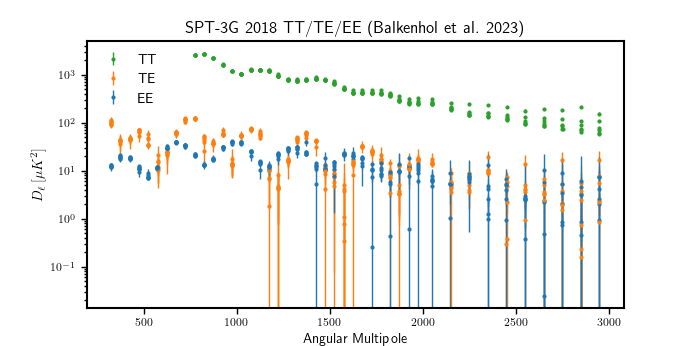

In [3]:
# Plot the band powers!
# This is a simple plotting strict that accesses candl_like.data_bandpowers
plt.close()
candl.plots.plot_band_powers(candl_like, colour_by_spec_type=True)
plt.show()

# Interfacing with Theory Codes and Evaluating the Likelihood

Below we initialise CAMB as an example theory code and use the interface tools to create a simple function that moves from a dictionary of parameter values to CMB spectra.
We then pass the spectra, along with the parameter values, to the likelihood to obtain the log likelihood value and the $\chi^2$.
Lastly, we plot the residuals.

In [4]:
# Initialise CAMB
CAMB_pars = camb.CAMBparams()
CAMB_pars.set_for_lmax(candl_like.ell_max+200, lens_potential_accuracy=2)
CAMB_pars_to_theory_specs = candl.interface.get_CAMB_pars_to_theory_specs_func(CAMB_pars)# this function takes a dictionary of cosmological parameters and returns a dictionary of CMB spectra


In [5]:
# Define fiducial parameters, cosmology matches Planck 2018 best fit
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054}

# Nuisance parameters are set to the central values of their priors
for par_name in candl_like.required_nuisance_parameters:
    for prior in candl_like.priors:
        if par_name in prior.par_names:
            fid_pars[par_name] = prior.central_value[prior.par_names.index(par_name)]


In [6]:
# Get the theory spectra from CAMB
CAMB_CMB_Dls = CAMB_pars_to_theory_specs(fid_pars, candl_like.ell_max)

# Hand off to the likelihood
pars_for_like = deepcopy(fid_pars)
pars_for_like["Dl"] = CAMB_CMB_Dls
logl_value = candl_like.log_like(pars_for_like)
chisq_value = candl_like.chi_square(pars_for_like)

# Print results
# Note that for likelihoods with a varying beam covariance matrix the chi-square value is not twice the log-likelihood value
print(f"logL = {sigfig.round(float(logl_value), decimals=1)}")
print(f"chisq = {sigfig.round(float(chisq_value), decimals=1)}")


logL = -1033.5
chisq = 958.9


In [7]:
# Transform CMB spectra and bin
model_spectrum = candl_like.get_model_specs(pars_for_like)
binned_model_spectrum = candl_like.bin_model_specs(model_spectrum)

# Calculate error bars
# Note that we need to add the beam correlation matrix to the covariance
error_bars = np.sqrt(np.diag(candl_like.covariance) + np.diag(candl_like.beam_correlation) * binned_model_spectrum**2)

# Calculate residuals
residuals = binned_model_spectrum - candl_like.data_bandpowers
relative_residuals = residuals / error_bars


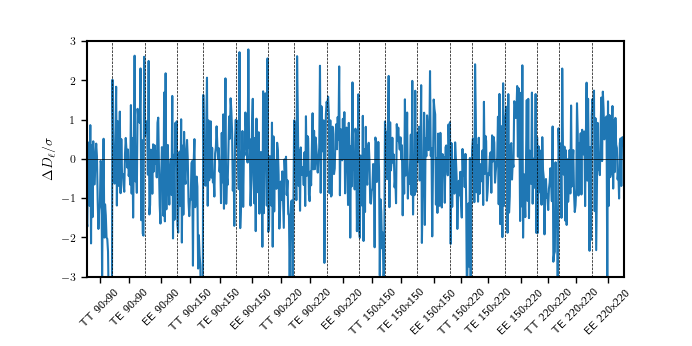

In [8]:
# Plot the residuals
plt.close()

# Set figure size
fig = plt.gcf()
fig.set_size_inches(2 * 3.464, 1 * 3.464)

# Plot residuals and horizonal line
plt.plot(relative_residuals)
plt.axhline(0, color="k", lw=0.5)

# Dividers for spectra
for i, spec in enumerate(candl_like.spec_order[:-1]):    
    plt.axvline(candl_like.bins_stop_ix[i], color="k", ls="--", lw=0.5)

# Finish plot with limits, ticks, labels
plt.xlim(0, len(relative_residuals)-1)
plt.ylim((-3, 3))
plt.xticks(candl_like.bins_start_ix+(candl_like.bins_stop_ix-candl_like.bins_start_ix)/2,
           candl_like.spec_order,
           rotation=45)
plt.subplots_adjust(bottom=0.2)
plt.ylabel(r"$\Delta D_\ell / \sigma$")

plt.show()


# Run MCMC Chains with Cobaya

We not interface the likelihood with Cobaya.
First we access Cobaya's model interface, then we run MCMC chains.
Finally, we cast the samples into a getdist object and plot them.


In [10]:
# Wrap the likelihood for cobaya.
cobaya_info = {}

# This function returns a subclass of cobaya.likelihood.Likelihood with our likelihood pasted in along with all its requirements.
cobaya_info["likelihood"] = candl.interface.get_cobaya_info_dict_for_like(candl_like)

# Prepare the remainder of the info dictionary for Cobaya.
# This code is adapted from cobaya's input generator program.
# More information on the format etc. on the Cobaya website.
cobaya_info["params"] = {'H0': {'latex': 'H_0',
                                'prior': {'max': 80, 'min': 55},
                                'proposal': 1.0},
                         'logA': {'latex': '\\log(10^{10} A_\\mathrm{s})',
                                  'prior': {'max': 3.2, 'min': 2.7},
                                  'proposal': 0.005},
                         'As': {'latex': 'A_\\mathrm{s}',
                                'value': 'lambda logA: 1e-10*np.exp(logA)'},
                         'ns': {'latex': 'n_\\mathrm{s}',
                                'prior': {'max': 1.13, 'min': 0.868},
                                'proposal': 0.01},
                         'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2',
                                   'prior': {'max': 0.026, 'min': 0.018},
                                   'proposal': 0.00015},
                         'omch2': {'latex': '\\Omega_\\mathrm{c} h^2',
                                   'prior': {'max': 0.16, 'min': 0.09},
                                   'proposal': 0.0025},
                         'tau': {'latex': '\\tau_\\mathrm{reio}',
                                 'prior': {'max': 0.09, 'min': 0.018},
                                 'proposal': 0.005}}

# Use CAMB as a theory code with more or less the same accuracy parameters as above.
cobaya_info["theory"] = {'camb': {'extra_args': {"lmax": candl_like.ell_max+200,
                                                 'lens_potential_accuracy': 2,
                                                 'theta_H0_range': [20, 100]}}}

# Sampler information. In practice, you can point to a proposal matrix here.
cobaya_info["sampler"] = {'mcmc': {'max_samples': 100}}


In [11]:
# Add nuisance parameters as sampled parameters to Cobaya
# Instead of spelling them all out above, we add them programatically and allow them to vary within 10 sigma of their prior central values.
for par_name in candl_like.required_nuisance_parameters:
    for prior in candl_like.priors:
        if par_name in prior.par_names:
            
            # Grab the prior central value and width
            prior_central_val = float(prior.central_value[prior.par_names.index(par_name)])
            prior_width = np.sqrt(np.diag(prior.prior_covariance)[prior.par_names.index(par_name)])
            
            # Add to Cobaya's parameters
            cobaya_info["params"][par_name] = {'prior':
                                               {'min': prior_central_val-10*prior_width,
                                                'max': prior_central_val+10*prior_width},
                                               'ref': prior_central_val,
                                               'proposal': prior_width,
                                               'latex': par_name}


In [12]:
# Access Cobaya's model wrapper
# We evaluate the likelihood at the same point as above and get the same logL value (bar some slightly different CAMB settings).
model = cobaya.get_model(cobaya_info)
cobaya_logl = model.loglike(fid_pars)[0]
print(f"Cobaya logL = {sigfig.round(float(cobaya_logl), decimals=1)}")
print(f"Delta logL = {sigfig.round(float(cobaya_logl-logl_value), sigfigs=2)}")



[model] *WARNING* Ignored blocks/options: ['sampler']
[camb] `camb` module loaded successfully from /Users/lennart/.pyenv/versions/3.10.3/lib/python3.10/site-packages/camb
Cobaya logL = -1033.5
Delta logL = -1e-05


In [13]:
# We now run Cobaya's Metropolis-Hastings sampler until we get 100 accepted samples.
# This takes approximately 1-2 minutes on a laptop. You can speed this up by using a proposal matrix.
updated_info, sampler = run(cobaya_info)


[camb] `camb` module loaded successfully from /Users/lennart/.pyenv/versions/3.10.3/lib/python3.10/site-packages/camb
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.


[root] *WARNING* outlier fraction 0.12 


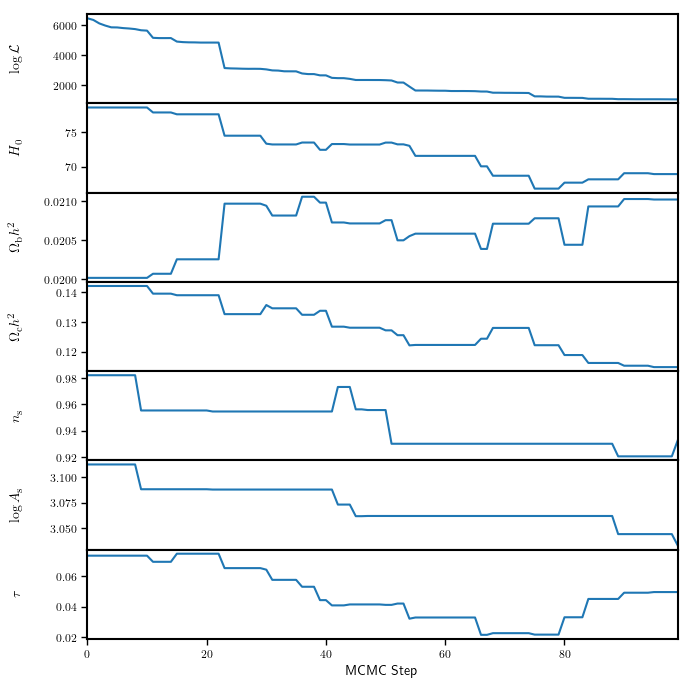

In [26]:
# Cast Cobaya samples into getdist object holding the same information.
# The outlier fraction warning appears, because we have few samples and do not crop burn-in.
gd_samples = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])


# Plot the samples of the MCMC chain.
# Only focus on cosmological parmeters here and the log likelihood.
plt.close()

fig, ax = candl.plots.plot_mcmc_chain_steps(gd_samples,# samples to plot
                                            ["H0", "ombh2", "omch2", "ns", "logA", "tau"])# parameters to plot

plt.tight_layout()

plt.show()
